In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # will not show deprecation warning
def warn(*args, **kwargs):
    pass
warnings.warn = warn  # avoid other warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

X = np.load("data\p2_unsupervised\X.npy")
print(X.shape)

# Part 1: Visualization

A scientist tells you that cells in the brain are either excitatory neurons, inhibitory neurons, or non-neuronal cells. Cells from each of these three groups serve different functions within the brain. Within each of these three types, there are numerous distinct sub-types that a cell can be, and sub-types of the same larger class can serve similar functions. Your goal is to produce visualizations which show how the scientist's knowledge reflects in the data.

As in Problem 1, we recommend using PCA before running T-SNE or clustering algorithms, for quality and computational reasons.

### (3 points) Provide at least one visualization which clearly shows the existence of three main brain cell types as described by the scientist, and explain how it shows this. Your visualization should support the idea that cells from different groups can differ greatly.

**Log Transformation**

  Due to the presence of high magnitude of data in only few cells in the genes, it is good to apply log transform to the data.

In [ ]:
Xlog = np.log2(X+1)
print(Xlog.shape)

Before getting to visualization, lets run a quick analysis on the data.

In [ ]:
df = pd.DataFrame(Xlog)
df[0].describe()

### Principal Component Analysis (PCA)

Principal component analysis is one of the techniques used to analyze data with high dimensions.  It is often used to find a low dimensional representation of the data that maximizes the spread of the projected data. 

In [ ]:
pca = PCA()
pca_comps = pca.fit_transform(Xlog)

# variance explained
variances = pca.explained_variance_ratio_
print("Varianced explained by 1st component = {}".format(variances[0]))


In [ ]:
labels = ["excitatory neurons", "inhibitory neurons", "non-neuronal cells"]
# visualize the PCA1 Vs PCA2
plt.scatter(pca_comps[0],pca_comps[1])
plt.title("Scatter plot of 1st and 2nd PCs",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()


In [ ]:

# visualize the variances 
comps = [i+1 for i in range(Xlog.shape[0])]
fig,ax=plt.subplots()
ax.plot(comps[0:101], variances[0:101])
ax.axvline(x=4, color='y',linestyle='--')
plt.title("% Explained variance by component",size=18)
plt.xlabel("Component #",size=14)
plt.ylabel("% Variance Explained",size=14)
plt.show()


In [ ]:
# calculate the total variability and look for 85% threshold
cdf = np.cumsum(variances)
fig,ax=plt.subplots()
ax.plot(comps,cdf,label="cdf")
ax.axhline(y=0.85,color='r',linestyle='dashed')
ax.axvline(x=1250, color='r',linestyle='dashed')
plt.xlabel("Components")
plt.ylabel("Variance Explained")
plt.title("Variance Explained vs Number of Componenet  Data")
plt.show()

Based on the above diagram, we can infer that 85% variance can be explained by 1250 components. Hence lets only consider the 1250 components of PCA

In [ ]:

transfrm_pca = pca.transform(Xlog)[:,:1250]
kmeans = KMeans(n_clusters=3, random_state=0).fit(transfrm_pca[:,:1250])
plt.scatter(transfrm_pca[:,0],transfrm_pca[:,1])

plt.show()

## T-SNE

In [ ]:
tsne = TSNE()
tsne_trns = tsne.fit_transform(transfrm_pca)

plt.title("T-SNE with PCA init")
plt.scatter(tsne_trns[:,0],tsne_trns[:,1])
plt.show()


In [ ]:
# TSNE  with PCA initialization
tsne_50 = TSNE(init='pca', perplexity=50)
tsne_15 = TSNE(init='pca', perplexity=15)
tsne_5 = TSNE(init='pca', perplexity=5)
tsne_trns_50 = tsne_50.fit_transform(transfrm_pca)
tsne_trns_15 = tsne_15.fit_transform(transfrm_pca)
tsne_trns_5 = tsne_5.fit_transform(transfrm_pca)


# plt.rcParams["figure.figsize"] = (15,15) 

# plt.subplot(1,3,1)
plt.scatter(tsne_trns_50[:,0],tsne_trns_50[:,1])
plt.title("T-SNE with PCA init, perplexity=50")
# plt.grid()
plt.show()

# plt.subplot(1,3,2)
plt.scatter(tsne_trns_15[:,0],tsne_trns_15[:,1])
plt.title("T-SNE with PCA init, perplexity=15")
# plt.grid()
plt.show()

# plt.subplot(1,3,3)
plt.scatter(tsne_trns_5[:,0],tsne_trns_5[:,1])
plt.title("T-SNE with PCA init, perplexity=5")
# plt.grid()
plt.show()

In [ ]:
# use silhoute score to estimate the number of clusters needed
def get_bestCluster(data):
    from sklearn.metrics import  silhouette_score
    from sklearn.model_selection import ParameterGrid
    # candidate values for our number of cluster
    parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]
    # instantiating ParameterGrid, pass number of clusters as input
    parameter_grid = ParameterGrid({'n_clusters': parameters})
    best_score = -1
    kmeans_model = KMeans()     # instantiating KMeans model
    silhouette_scores = []
    # evaluation based on silhouette_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)    # set current hyper parameter
        kmeans_model.fit(data)          # fit model on wine dataset, this will find clusters based on parameter p
        ss = silhouette_score(data, kmeans_model.labels_)   # calculate silhouette_score
        silhouette_scores += [ss]       # store all the scores
        print('Parameter:', p, 'Score', ss)
        # check p which has the best score
        if ss > best_score:
            best_score = ss
            best_grid = p
    # plotting silhouette score
    plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    plt.xticks(range(len(silhouette_scores)), list(parameters))
    plt.title('Silhouette Score', fontweight='bold')
    plt.xlabel('Number of Clusters')
    plt.show()
    return best_grid

In [ ]:
# Kmeans clusteting using TSNE Transformation. We will set the cluster =3 as there are three main brain cell types
get_bestCluster(transfrm_pca )
# kmeans = KMeans(n_clusters=3, random_state=0).fit(tsne_trns_50[:,:1250])
# ss = silhouette_score(tsne_trns_50, kmeans.labels_)   # calculate silhouette_score
# print(ss)
# # plt.scatter(tsne_trns_50[:,0], tsne_trns_50[:,1], c=kmeans.labels_)
# # plt.title("T-SNE with init=PCA, perplexity=50")

### (4 points) Provide at least one visualization which supports the claim that within each of the three types, there are numerous possible sub-types for a cell. In your visualization, highlight which of the three main types these sub-types belong to. Again, explain how your visualization supports the claim.

For visualizing the cluster hetrogeneity in the data we can use K-mean with MDS (multi-dimensional scaling).First 

In [ ]:
embedding = MDS(n_components=2)
mds = embedding.fit_transform(Xlog[:,:1250])
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(mds)
plt.scatter(mds[:,0],mds[:,1], c=kmeans.labels_)
plt.title('MDS')
plt.show()

After the model has been fitted we need to have the centroids of all the clusters. For this you can use this.

In [ ]:
k_means_cluster_centers = kmeans.cluster_centers_

Then we need to know to what cluster all the datapoints in X belong to. For this you can use pairwise_distances_argmin this function returns the cluster any set of points have as their closest centroid.

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances_argmin, euclidean_distances
k_means_labels = pairwise_distances_argmin(mds, k_means_cluster_centers)

Then you need to compute the heterogeneity of all the clusters. To do this we need the following for loop and the euclidean_distances function. euclidean_distances calculates the euclidean distance between points.

In [ ]:
for i,j in enumerate(set(k_means_labels)):
    positions=mds[np.where(k_means_labels == i)]
    output=sum(euclidean_distances(positions,k_means_cluster_centers[j].reshape(1,-1)))
    print('cluster {} has a  heterogeneity of {}'.format(i,output))

In this loop we get all the values of X that belong to a cluster. Calculate the euclidean distance of all points to the centroid of that cluster. Take the sum and print the output.

### create an heirarchial cluster to get the subtypes in each clusters

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(mds, method='ward'))
plt.axhline(y=850,color='r',linestyle='dashed')
plt.show()

In [ ]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(tsne_trns_50, method='ward'))

# Part 2: Unsupervised Feature Selection

Now we attempt to find informative genes which can help us differentiate between cells, using only unlabeled data. A genomics researcher would use specialized, domain-specific tools to select these genes. We will instead take a general approach using logistic regression in conjunction with clustering. Briefly speaking, we will use the p2_unsupervised dataset to cluster the data. Treating those cluster labels as ground truth, we will fit a logistic regression model and use its coefficients to select features. Finally, to evaluate the quality of these features, we will fit another logistic regression model on the training set in p2_evaluation, and run it on the test set in the same folder.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # will not show deprecation warning
def warn(*args, **kwargs):
    pass
warnings.warn = warn  # avoid other warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

X = np.load('data/p2_unsupervised_reduced/X.npy')

In [2]:
# normalize the training data
Xlog  = np.log2(X+1)
Xlog.max()

18.38035739241839


**1.	(4 points) Using your clustering method(s) of choice, find a suitable clustering for the cells. Briefly explain how you chose the number of clusters by appropriate visualizations and/or numerical findings. (To cluster cells into the subcategories instead of categories)**

Let us use T-SNE transformation and WGSS for finding the number of possible clusters in the dataset

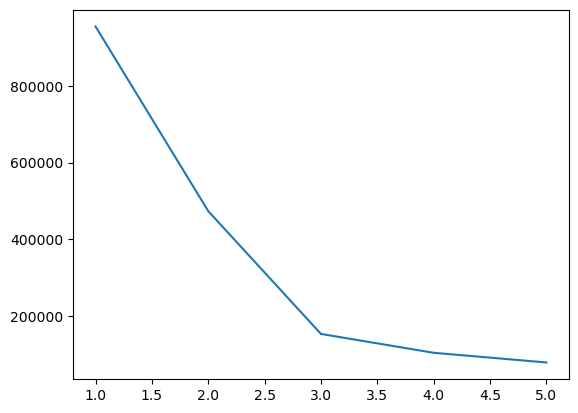

In [3]:
tsne = TSNE()
tsne_trnf = tsne.fit_transform(Xlog)
clusterCounter = [i for i in range(1,6)]
WGSS=[]
for _c in clusterCounter:    
    kmeans = KMeans(n_clusters=_c, random_state=0).fit(tsne_trnf)    
    WGSS.append(kmeans.inertia_)
plt.plot(clusterCounter, WGSS)

It looks like we have 3 cluster that gives best result. we will choose 3 for clustering. Now we will assign psudo label to every data point.

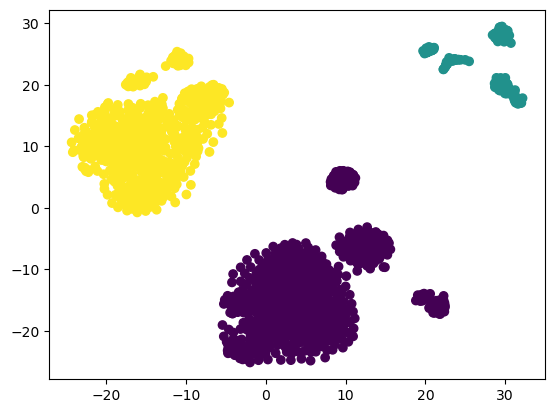

In [4]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(tsne_trnf)
plt.scatter(tsne_trnf[:,0], tsne_trnf[:,1], c=kmeans.labels_)
plt.show()


In [5]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

penalties = ['l1','l2','elasticnet']
l1_ratio = [0.1, 0.2,0.3,0.4,0.5,0.6,0.25,0.75,1]
Y = kmeans.predict(tsne_trnf)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print("Train Data shape {} ".format(X_train.shape))
print("Test Data shape {} ".format(X_test.shape))

Train Data shape (1453, 20000) 
Test Data shape (716, 20000) 


In [6]:
classfier_dict = {} 
for i in penalties:
    if i == 'elasticnet':
        for r in l1_ratio:
            clf = LogisticRegression(random_state=0, penalty=i,l1_ratio=r, multi_class='ovr', solver='saga', max_iter=200).fit(X_train, y_train)
            score = clf.score(X_test,y_test)
            if i not in classfier_dict:
                classfier_dict[i]=[]
            classfier_dict[i].append({'score':score, 'ratio':r, 'model':clf,'penalty':i })
        
    else:
        clf = LogisticRegression(random_state=0, penalty=i, multi_class='ovr' , solver='liblinear', max_iter=200).fit(X_train, y_train)
        score = clf.score(X_test,y_test)
        if i not in classfier_dict:
            classfier_dict[i]=[]
        classfier_dict[i].append({'score':score, 'penalty':i, 'model':clf })

lr_clf = LogisticRegression(random_state=10, penalty='l1', multi_class='ovr', solver='liblinear').fit(X_train, y_train)
score = lr_clf.score(X_test,y_test)
print(score)

0.9986033519553073


In [7]:
classfier_dict

{'l1': [{'score': 0.9986033519553073,
   'penalty': 'l1',
   'model': LogisticRegression(max_iter=200, multi_class='ovr', penalty='l1',
                      random_state=0, solver='liblinear')}],
 'l2': [{'score': 0.9986033519553073,
   'penalty': 'l2',
   'model': LogisticRegression(max_iter=200, multi_class='ovr', random_state=0,
                      solver='liblinear')}],
 'elasticnet': [{'score': 0.9986033519553073,
   'ratio': 0.1,
   'model': LogisticRegression(l1_ratio=0.1, max_iter=200, multi_class='ovr',
                      penalty='elasticnet', random_state=0, solver='saga'),
   'penalty': 'elasticnet'},
  {'score': 0.9986033519553073,
   'ratio': 0.2,
   'model': LogisticRegression(l1_ratio=0.2, max_iter=200, multi_class='ovr',
                      penalty='elasticnet', random_state=0, solver='saga'),
   'penalty': 'elasticnet'},
  {'score': 0.9986033519553073,
   'ratio': 0.3,
   'model': LogisticRegression(l1_ratio=0.3, max_iter=200, multi_class='ovr',
               

# top 100 features

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_train = np.load('data/p2_evaluation/X_train.npy')
y_train = np.load('data/p2_evaluation/y_train.npy')
X_test = np.load('data/p2_evaluation/X_test.npy')
y_test = np.load('data/p2_evaluation/y_test.npy')

X_train = np.log2(X_train+1)
X_test = np.log2(X_test+1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)